In [1]:
from backtesting import Backtest, Strategy
import yfinance as yf
import talib
from backtesting.lib import crossover
import pandas as pd
from backtesting.test import GOOG, SMA
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split



/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## For demonstration purposes: code below is for demonstrating the use of Relative Strength Index (RSI) on S&P500 data

### Example Strategy

In [ ]:
class RsiOscillator(Strategy):

    upper_bound = 70
    lower_bound = 30

    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, 14)
 
    def next(self):

        if crossover(self.rsi, self.upper_bound):
            self.position.close()

        elif crossover(self.lower_bound, self.rsi):
            self.buy()


### Data Loading

In [10]:
df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']]= df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
print(df.columns)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None
print(df)


Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA5',
       'MA10', 'MA20', 'Volatility', 'Momentum', 'Target'],
      dtype='object')
                  Close         High          Low         Open        Volume  \
2020-01-30  3283.659912  3285.909912  3242.800049  3256.449951  3.790350e+09   
2020-01-31  3225.520020  3282.330078  3214.679932  3282.330078  4.529700e+09   
2020-02-03  3248.919922  3268.439941  3235.659912  3235.659912  3.760460e+09   
2020-02-04  3297.590088  3306.919922  3280.610107  3280.610107  3.996900e+09   
2020-02-05  3334.689941  3337.580078  3313.750000  3324.909912  4.121480e+09   
...                 ...          ...          ...          ...           ...   
2023-12-22  4754.629883  4772.939941  4736.770020  4753.919922  3.046770e+09   
2023-12-26  4774.750000  4784.720215  4758.450195  4758.859863  2.513910e+09   
2023-12-27  4781.580078  4785.390137  4768.899902  4773.450195  2.748450e+09   
2023-12-28  4783.350098  4793.299805  4780.

In [11]:
bt = Backtest(df, RsiOscillator, cash = 10_000)

In [12]:
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/972 [00:00<?, ?bar/s]

Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    43.26241
Equity Final [$]                  12652.18066
Equity Peak [$]                   12669.40039
Return [%]                           26.52181
Buy & Hold Return [%]                41.40246
Return (Ann.) [%]                     6.19028
Volatility (Ann.) [%]                17.49927
CAGR [%]                              4.23572
Sharpe Ratio                          0.35375
Sortino Ratio                         0.53768
Calmar Ratio                          0.24592
Alpha [%]                             1.53349
Beta                                  0.60355
Max. Drawdown [%]                   -25.17149
Avg. Drawdown [%]                    -4.21311
Max. Drawdown Duration      246 days 00:00:00
Avg. Drawdown Duration       46 days 00:00:00
# Trades                                    4
Win Rate [%]                      

/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=27: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=30: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=674: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=944: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(


In [13]:
bt.plot()

GridPlot(id='p1782', ...)

# Advanced Demo
## For demonstration purposes, the code below is used to construct a K nearest neighbor ML moving prediction

### Helper function and Data Cleaning

In [ ]:
data = df

def BBANDS(data, n_lookback, n_std):
    """Creates Bollinger Band indicators"""
    # HCL3 = the average between the high, low and close price for a given day
    hlc3 = (data.High + data.Low + data.Close) / 3
    # Calculates a rolling mean and standard deviation over n_lookback periods
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()

    # Creates the upper and lower bands that are how many standard deviations away from the HCL3
    upper = mean + n_std*std
    lower = mean - n_std*std

    return upper, lower


# This function extracts the features, in the context of this model, it extracts "X_SMA10", "X_DELTA_SMA10", "X_MOM", "X_BB_upper", etc
def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Calculates the percentage change in closing price 48 periods ahead
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%

    # Converts positive returns to 1
    # Converts negative returns to -1
    y[y > 0] = 1          
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    # Gets feature X and target y
    # Removes any rows that have NaN and return the cleaned data
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y


# Calculates simple moving averages for different periods (10,20,50,100)
# See investopedia for the definition of simple moving average
close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features (normalized difference between close price and SMAs)
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

# Difference between consecutive SMAs
data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features

# 2 period momentum (percentage change in the closing price)
data['X_MOM'] = data.Close.pct_change(periods=2)

# Normalized sitance to upper/lower Bollinger Bands
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close

# Normalized Bollinger Band width (volatility)
data['X_BB_width'] = (upper - lower) / close

# Sentiment feature based on specific date range
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek # (0-6)
data['X_hour'] = data.index.hour    # (0-23)

# Clean some of the data
data = data.dropna().astype(float)


### Model Training 

Classification accuracy:  0.6714285714285714


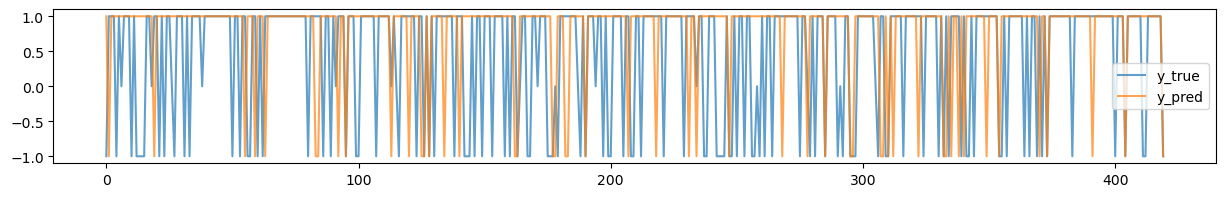

In [14]:
# Separate the X and the Ys to prepare for ML training
X, y = get_clean_Xy(data)

# Split 50% into testing and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

# Trains k-Nearest neighbors classifier with 7 neighbors
clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

# Predict 
y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))



Classification accuracy:  0.6714285714285714


Backtest.run:   0%|          | 0/887 [00:00<?, ?bar/s]

/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=800: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=801: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=802: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=803: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=804: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954:

Start                     2020-06-22 00:00:00
End                       2023-12-29 00:00:00
Duration                   1285 days 00:00:00
Exposure Time [%]                    45.83333
Equity Final [$]                   1006.32535
Equity Peak [$]                       10000.0
Commissions [$]                    1609.34994
Return [%]                          -89.93675
Buy & Hold Return [%]                 6.40458
Return (Ann.) [%]                   -47.88133
Volatility (Ann.) [%]                 6.88257
CAGR [%]                            -36.25765
Sharpe Ratio                         -6.95689
Sortino Ratio                        -3.68458
Calmar Ratio                         -0.53239
Alpha [%]                           -90.89965
Beta                                  0.15035
Max. Drawdown [%]                   -89.93675
Avg. Drawdown [%]                   -89.93675
Max. Drawdown Duration      708 days 00:00:00
Avg. Drawdown Duration      708 days 00:00:00
# Trades                          

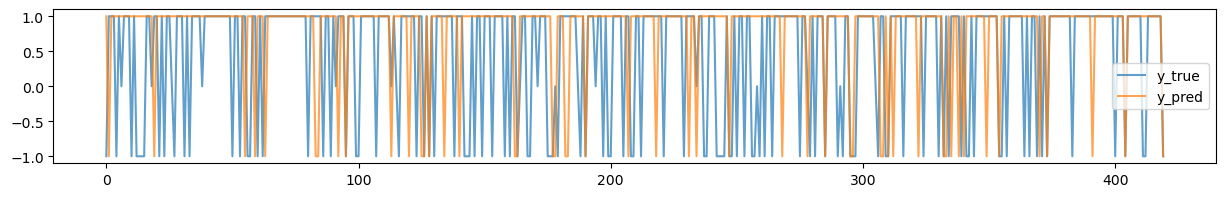

In [ ]:

# ---------------------------------------------------------------------------
# BELOW IS THE INTEGRATION OF THE ML MODEL TO THE STRATEGY
# ---------------------------------------------------------------------------

# Number of Samples
N_TRAIN = 400



class MLTrainOnceStrategy(Strategy):
    # Risk management strategy so the maximum profit is < 0.4% of current price and maximum loss is < 0.4% of current price
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()



In [88]:
bt.plot()

GridPlot(id='p2578', ...)

In [89]:
%%time

class MLWalkForwardStrategy(MLTrainOnceStrategy):
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return

        # Re-train the model only every 20 iterations.
        # Since 20 << N_TRAIN, we don't lose much in terms of
        # "recent training examples", but the speed-up is significant!
        if len(self.data) % 20:
            return super().next()

        # Retrain on last N_TRAIN values
        df = self.data.df[-N_TRAIN:]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        super().next()


bt = Backtest(data, MLWalkForwardStrategy, commission=.0002, margin=.05)
bt.run()


Backtest.run:   0%|          | 0/887 [00:00<?, ?bar/s]

CPU times: user 362 ms, sys: 49.2 ms, total: 411 ms
Wall time: 701 ms


/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=796: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=797: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=798: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=799: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=800: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954:

Start                     2020-06-22 00:00:00
End                       2023-12-29 00:00:00
Duration                   1285 days 00:00:00
Exposure Time [%]                    45.38288
Equity Final [$]                   1011.84866
Equity Peak [$]                       10000.0
Commissions [$]                    1730.05936
Return [%]                          -89.88151
Buy & Hold Return [%]                 6.40458
Return (Ann.) [%]                   -47.80031
Volatility (Ann.) [%]                 6.90983
CAGR [%]                            -36.18919
Sharpe Ratio                         -6.91773
Sortino Ratio                        -3.68758
Calmar Ratio                         -0.53181
Alpha [%]                            -89.8574
Beta                                 -0.00377
Max. Drawdown [%]                   -89.88151
Avg. Drawdown [%]                   -89.88151
Max. Drawdown Duration      708 days 00:00:00
Avg. Drawdown Duration      708 days 00:00:00
# Trades                          

In [90]:
bt.plot()

GridPlot(id='p3033', ...)